# 🏦 Bank Customer Segmentation


## 📚 Table of Contents
### 1️⃣ Data Preparation & Exploration
- [1.1 📥 Import Libraries & Load Data](#import-libraries)

### 2️⃣ Data Cleaning & Preprocessing
- [2.1 🧹 Clean Missing Values](#clean-missing)
- [2.2 🔄 Create RFM Features](#rfm)
- [2.3 📏 Handle Outliers](#handle-outliers)

### 3️⃣ Exploratory Data Analysis
- [3.1 📊 Exploratory Data Analysis (EDA)](#exploratory-data-analysis)

### 4️⃣ Feature Engineering
- [4.1 🔍 Scaling & Feature Engineering](#scaling-encoding)

### 5️⃣ Model Development
- [5.1 🔄 Implement K-Mean](#kmean)
- [5.2 🤖 Implement DBSCAN](#dbscan)
- [5.3 📊 Implement PCA](#pca)

### 6️⃣ Conclusions
- [6.1 💡 Key Insights](#key-insights)
- [6.2 📊 Model Explainability using SHAP](#SHAP)


---
## Goal of this Notebook🎯
- Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
- Perform Location-wise analysis to identify regional trends in India
- Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
- Customer Recency, Frequency, Monetary analysis
- Network analysis or Graph analysis of customer data.

<a id="import-libraries"></a>
## 1.1 📥 Import Libraries & Load Data


In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer


In [2]:
df = pd.read_csv(r"data/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


<a id="clean-missing"></a>
## **2.1 🧹 Clean Missing Values**

In [4]:
a = df['CustomerID'].nunique()
print(f"# unique customers:", a)
print(60*'-')
b = df['CustLocation'].nunique()
print(f"# unique locations:", b)
print(60*'-')
df['CustGender'].value_counts()

# unique customers: 884265
------------------------------------------------------------
# unique locations: 9355
------------------------------------------------------------


CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

In [5]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [7]:
# Convert datetime data
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

/tmp/ipykernel_22445/117616477.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
/tmp/ipykernel_22445/117616477.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])


In [8]:
df['Age'] =df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

In [9]:
df.drop(df[df['CustGender']=='T'].index,inplace=True)
num_col = df.select_dtypes(include=np.number)
cat_col = df.select_dtypes(exclude=np.number)

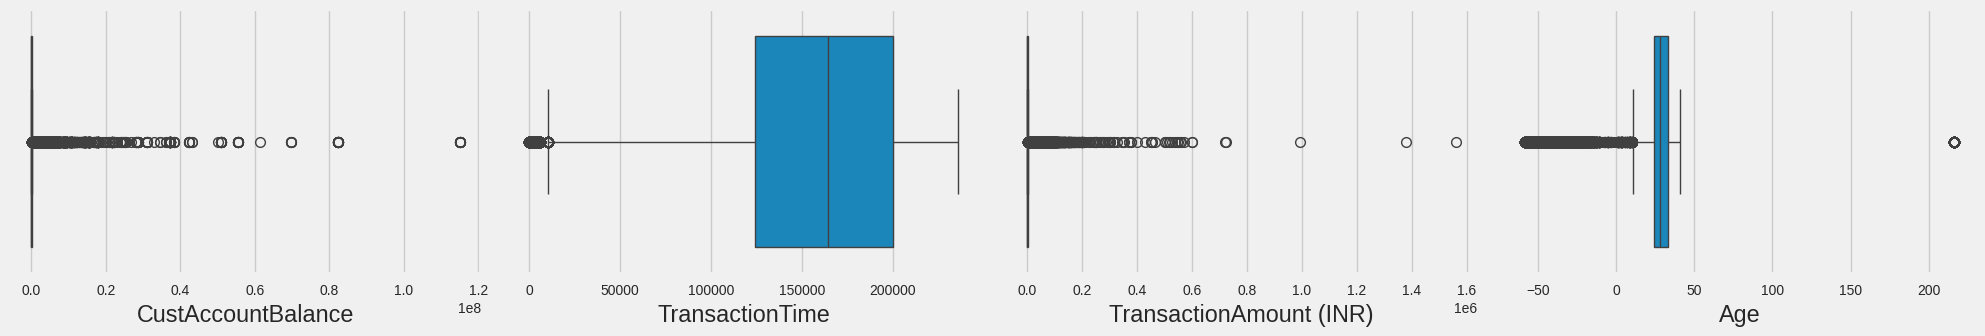

In [10]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,40))
for index,column in enumerate(num_col):
    plt.subplot(12,6,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

In [11]:
# The age is negative because anyone can open a Life Saver youth savings account on behalf of a child or grandchild so we will assign it to 0.
df.loc[df['Age'] < 0, 'Age'] = 0
# remove outliers
df = df[df['Age'] <= 100]

<function matplotlib.pyplot.show(close=None, block=None)>

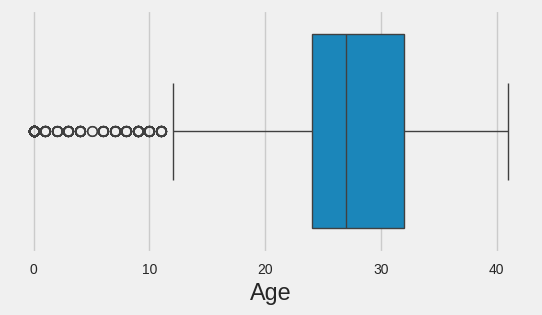

In [12]:
plt.figure(figsize=(6,3))
sns.boxplot(data=df, x='Age')
plt.show

<a id="rfm"></a>
## **2.2 🔄 Create RFM Features**

### Now we will create our RFM dataframe to make Customer RFM Analysis

In [13]:
df['TransactionDate1']=df['TransactionDate'] # for first transaction
df['TransactionDate2']=df['TransactionDate'] # for last transaction

# Creating MRF table
MRF_df = df.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "median",
                                        "TransactionAmount (INR)" : "mean",
                                        "Age" : "median",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

MRF_df = MRF_df.reset_index()
MRF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerID               839081 non-null  object        
 1   TransactionID            839081 non-null  int64         
 2   CustGender               839081 non-null  object        
 3   CustLocation             839081 non-null  object        
 4   CustAccountBalance       839081 non-null  float64       
 5   TransactionAmount (INR)  839081 non-null  float64       
 6   Age                      839081 non-null  float64       
 7   TransactionDate2         839081 non-null  datetime64[ns]
 8   TransactionDate1         839081 non-null  datetime64[ns]
 9   TransactionDate          839081 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(1), object(3)
memory usage: 64.0+ MB


In [14]:
MRF_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,0.0,2016-08-18,2016-08-18,2016-08-18


In [15]:
MRF_df['CustomerID'].nunique()

839081

In [16]:
MRF_df['TransactionID'].value_counts()

TransactionID
1    710185
2    113138
3     14291
4      1353
5       108
6         6
Name: count, dtype: int64

---
- ### Maximum amout of trx is 6 trx 
- ### our MRF df has no duplicated customer ID (which will avoid us from data leakage in the future)
---

### RFM is an appreviation for Recency, Frequency, and Monetary which is used a lot in the banking sector to know more about the customer.

- #### Recency: The Recent Customer Activity or Transaction.

- #### Frequency: The Frequency of Customer Transactions in a specific period of time.

- ####  Monetary: The Amount of spend in this period of time.

In [17]:
MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)
MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']
MRF_df['Recency']=MRF_df['Recency'].astype(str)
MRF_df['Recency'].value_counts()

Recency
0 days      712454
1 days        3102
31 days       2343
30 days       2302
61 days       2002
             ...  
287 days        16
58 days         13
265 days        12
266 days         8
206 days         6
Name: count, Length: 252, dtype: int64

In [18]:
# Extract the # of days only
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)
MRF_df['Recency'].value_counts()

Recency
0      712454
1        3102
31       2343
30       2302
61       2002
        ...  
287        16
58         13
265        12
266         8
206         6
Name: count, Length: 252, dtype: int64

In [19]:
MRF_df.rename(columns={"TransactionAmount (INR)":"Monetary"},inplace=True)

In [20]:
# 0 days mean that a customer has done transaction on the same day so we will replace it with 1
MRF_df.loc[MRF_df['Recency'] == 0, 'Recency'] = 1
MRF_df['Recency'].value_counts()

Recency
1      715556
31       2343
30       2302
61       2002
5        1702
        ...  
287        16
58         13
265        12
266         8
206         6
Name: count, Length: 251, dtype: int64

<a id="handle-outliers"></a>
## **2.3 📏 Handle Outliers**

In [21]:
df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

In [22]:
num_col = MRF_df.select_dtypes(include=np.number)
cat_col = MRF_df.select_dtypes(exclude=np.number)

In [23]:
num_col.drop(columns={"Frequency"}, inplace = True)
num_col.head()

,CustAccountBalance,Monetary,Age,Recency
0,76340.635,2553.0,28.5,18
1,24204.490,1499.0,22.0,1
2,100112.950,727.5,28.0,182
3,496.180,30.0,26.0,1
4,87058.650,5000.0,0.0,1


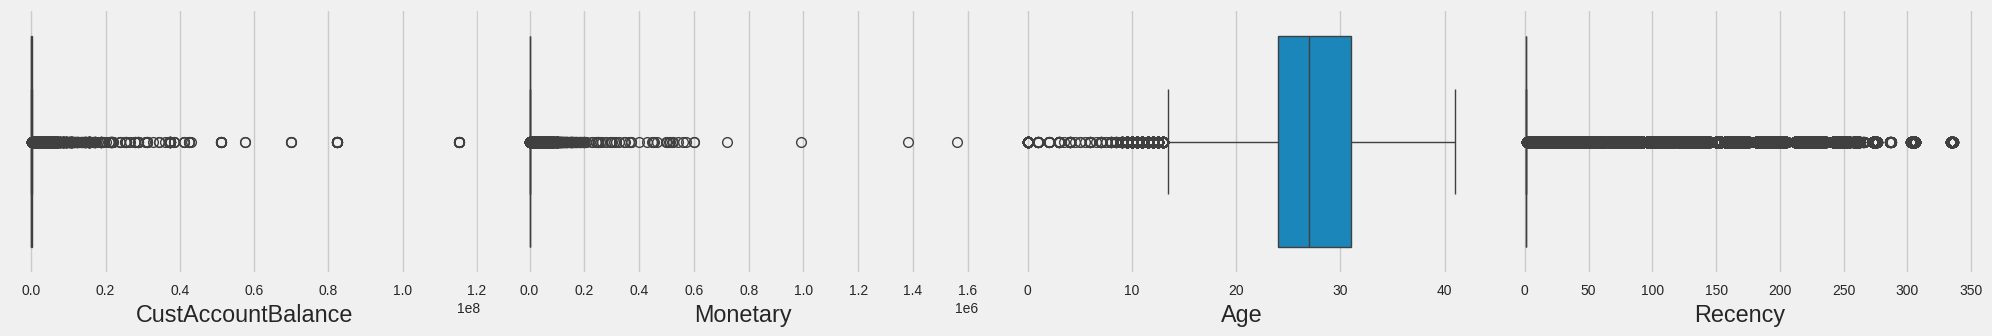

In [24]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,40))
for index,column in enumerate(num_col):
    plt.subplot(12,6,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

In [25]:
# to claculate the otliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['CustAccountBalance','Monetary', 'Age', 'Recency']
for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # calculate number of outliers
    num=MRF_df[(MRF_df[i] < lower) | (MRF_df[i] > upper)].shape[0]
    
    # calculate percentage of outliers
    perc = (num / MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))

dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }

In [26]:
outliers_df=pd.DataFrame(dic,index=['CustAccountBalance','Monetary', 'Age', 'Recency'])
outliers_df

,lower,upper,outliers,Perc%
CustAccountBalance,-70881.835,132270.445,109942,13.10
Monetary,-1313.595,2669.325,87229,10.40
Age,13.500,41.500,86169,10.27
Recency,1.000,1.000,123525,14.72


### they are seem like an outliers but actually they are not

---
<a id="exploratory-data-analysis"></a>
## **3.2 📊 Exploratory Data Analysis (EDA)**


In [27]:
MRF_df.head()

,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,Monetary,Age,TransactionDate,Recency
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1
4,C1010024,1,M,KOLKATA,87058.650,5000.0,0.0,2016-08-18,1


In [28]:
MRF_df.describe()

,Frequency,CustAccountBalance,Monetary,Age,TransactionDate,Recency
count,839081.000000,8.390810e+05,8.390810e+05,839081.000000,839081,839081.000000
mean,1.174287,1.045605e+05,1.453624e+03,25.670855,2016-07-25 20:32:16.587289856,15.132148
min,1.000000,0.000000e+00,0.000000e+00,0.000000,2016-01-08 00:00:00,1.000000
25%,1.000000,5.300270e+03,1.800000e+02,24.000000,2016-06-09 00:00:00,1.000000
50%,1.000000,1.736134e+04,4.750000e+02,27.000000,2016-08-19 00:00:00,1.000000
75%,1.000000,5.608834e+04,1.175730e+03,31.000000,2016-09-09 00:00:00,1.000000
max,6.000000,1.150355e+08,1.560035e+06,41.000000,2016-12-09 00:00:00,336.000000
std,0.435129,7.845063e+05,6.045200e+03,9.709297,NaN,45.535132


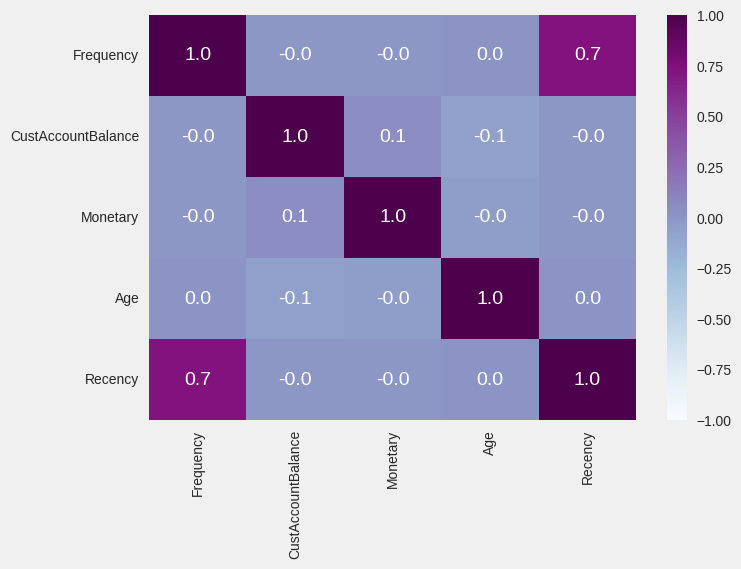

In [29]:
plt.figure(figsize=(7, 5))
correlation = MRF_df.select_dtypes(include=[float, int]).corr()

sns.heatmap(
    correlation,
    vmin=-1,          # allow full correlation range
    vmax=1,
    cmap='BuPu',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True
)
plt.show()


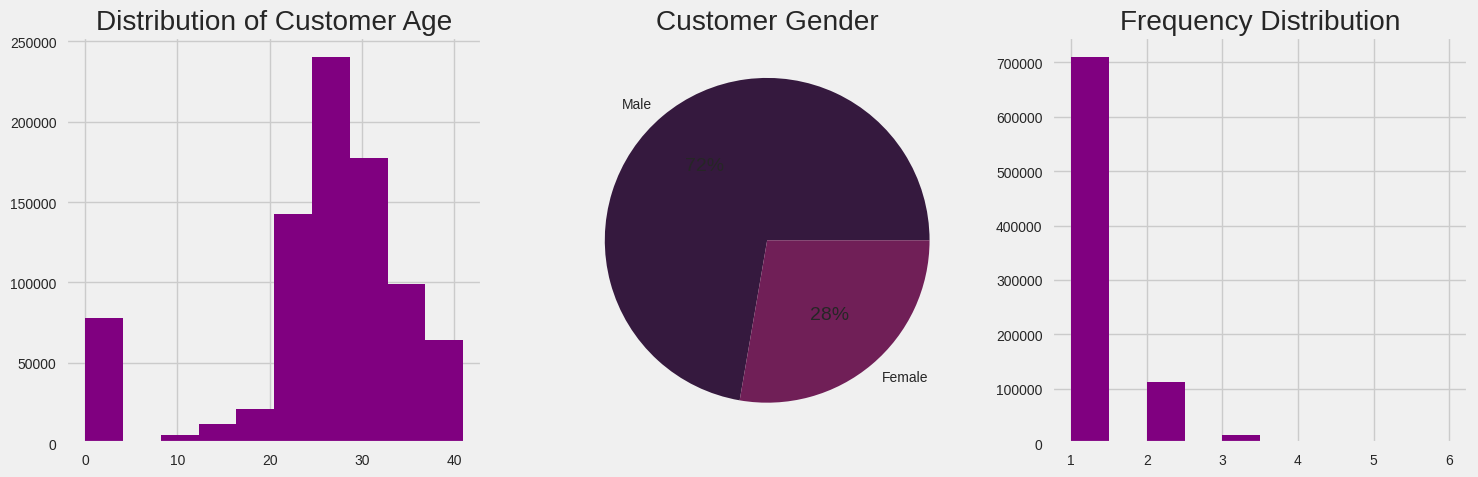

In [35]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=MRF_df['Age'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(MRF_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
ax[2].hist(x=MRF_df['Frequency'],color='purple')
ax[2].set_title("Frequency Distribution")
plt.tight_layout()

In [31]:
diff = MRF_df['Recency'].max()-MRF_df['Recency'].min()
print("Difference between maximum and minimum recency:", diff)

Difference between maximum and minimum recency: 335


In [32]:
MRF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CustomerID          839081 non-null  object        
 1   Frequency           839081 non-null  int64         
 2   CustGender          839081 non-null  object        
 3   CustLocation        839081 non-null  object        
 4   CustAccountBalance  839081 non-null  float64       
 5   Monetary            839081 non-null  float64       
 6   Age                 839081 non-null  float64       
 7   TransactionDate     839081 non-null  datetime64[ns]
 8   Recency             839081 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 57.6+ MB


In [33]:
MRF_df=MRF_df.sort_values(by='TransactionDate')
MRF = MRF_df.copy() 
MRF = MRF.drop(columns=['CustGender','CustLocation', 'CustomerID'])
monthly=MRF.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()

monthly

,Frequency,CustAccountBalance,Monetary,Age,Recency
TransactionDate,,,,,
2016-01-31,1.023535,99372.085049,1339.251024,25.877836,1.812399
2016-02-29,1.060922,92702.610831,1399.785006,25.885751,4.899824
2016-03-31,1.086487,103061.814759,1539.192142,25.874852,8.173665
2016-04-30,1.163838,104872.988638,1593.985274,25.812464,23.924108
2016-05-31,1.341184,99513.852863,1485.286222,25.737374,60.218238
2016-06-30,1.344024,100192.530204,1557.533949,25.813798,51.326862
2016-07-31,1.341087,94648.067452,1453.967449,25.787434,35.571659
2016-08-31,1.147972,110053.463340,1453.964534,25.573935,7.009712
2016-09-30,1.201000,106747.685580,1398.478069,25.604266,10.089098


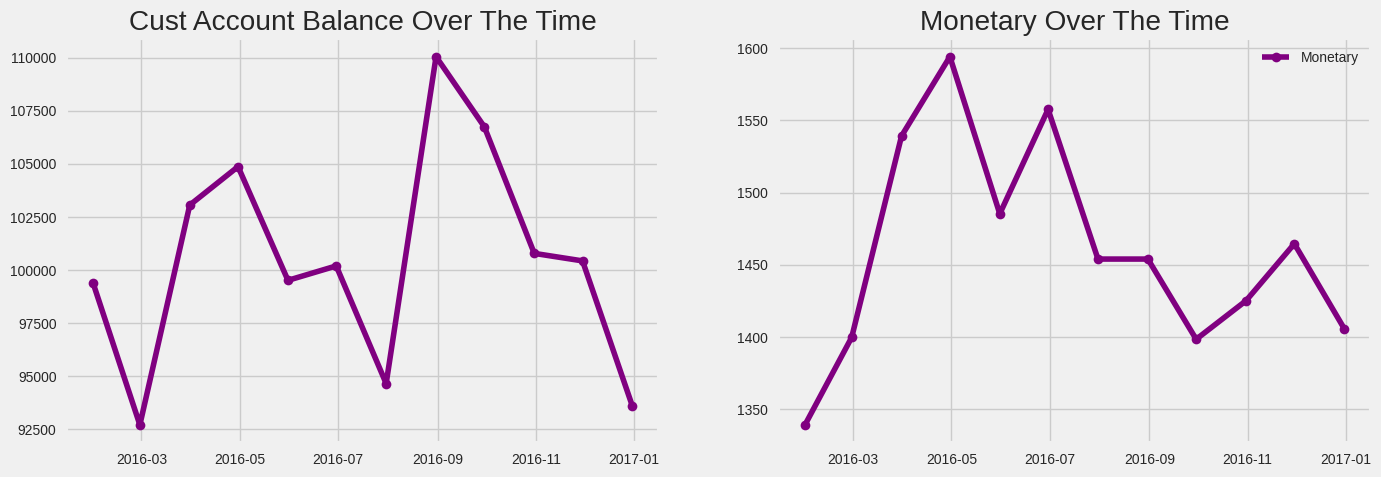

In [36]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(monthly.index,monthly['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(monthly.index,monthly['Monetary'],color='purple',marker='o',label='Monetary')
ax[1].set_title("Monetary Over The Time")
plt.legend() 

---
<a id="scaling-encoding"></a>
## **4.1 🔍 Scaling & Feature Engineering**


In [37]:
MRF_df=MRF_df.reset_index(drop=True) # drop=True means the old index is not added as a column
MRF_df.head()


,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,Monetary,Age,TransactionDate,Recency
0,C8233670,1,M,ANDHRA PRADESH,2293.07,1512.75,29.0,2016-01-08,1
1,C1121621,1,M,AHMEDABAD,3472.84,620.00,24.0,2016-01-08,1
2,C1781320,1,M,HOSUR,8385.86,2400.00,22.0,2016-01-08,1
3,C3327266,1,M,RANGA REDDY,37541.14,300.00,32.0,2016-01-08,1
4,C2123220,1,M,MUMBAI,17099.34,229.00,30.0,2016-01-08,1


In [38]:
MRF_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

In [39]:
MRF_df['CustGender']=MRF_df['CustGender'].map({'M':1,'F':0})


In [43]:
MRF_df.drop(columns=['CustomerID'],inplace=True)

In [44]:
scaler = StandardScaler()
df_scaled=scaler.fit_transform(MRF_df)
df_scaled=pd.DataFrame(df_scaled,columns=MRF_df.columns) # convert the scaled NumPy array back to DataFrame
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetary,Age,Recency
0,-0.400541,0.619109,-0.130359,0.009781,0.342882,-0.310357
1,-0.400541,0.619109,-0.128855,-0.137899,-0.172088,-0.310357
2,-0.400541,0.619109,-0.122593,0.156550,-0.378076,-0.310357
3,-0.400541,0.619109,-0.085429,-0.190833,0.651865,-0.310357
4,-0.400541,0.619109,-0.111486,-0.202578,0.445877,-0.310357


In [47]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Frequency           839081 non-null  float64
 1   CustGender          839081 non-null  float64
 2   CustAccountBalance  839081 non-null  float64
 3   Monetary            839081 non-null  float64
 4   Age                 839081 non-null  float64
 5   Recency             839081 non-null  float64
dtypes: float64(6)
memory usage: 38.4 MB


### Since the data is too large, we will sample it to make it easier to work with. We will use a random sample of 200,000 rows from the scaled dataframe.


In [48]:
df_scaled=df_scaled.sample(n=200000,random_state=42).reset_index(drop=True)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetary,Age,Recency
0,-0.400541,0.619109,-0.077011,-0.185321,0.445877,-0.310357
1,-0.400541,0.619109,-0.132205,-0.001427,1.269830,-0.310357
2,-0.400541,0.619109,-0.132837,0.452818,-0.069094,-0.310357
3,-0.400541,0.619109,0.357946,-0.157914,-2.643947,-0.310357
4,1.897629,-1.615225,-0.117748,-0.202413,0.394379,1.797906


---
<a id="kmean"></a>
## **5.1 🔄 Implement K-Mean**

- [5.2 🤖 Implement DBSCAN](#dbscan)
- [5.3 📊 Implement PCA](#pca)

In [49]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

# Silhouette score and inertia
inertias = []
silhouette_coefficients = []

for k in range(3,7):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

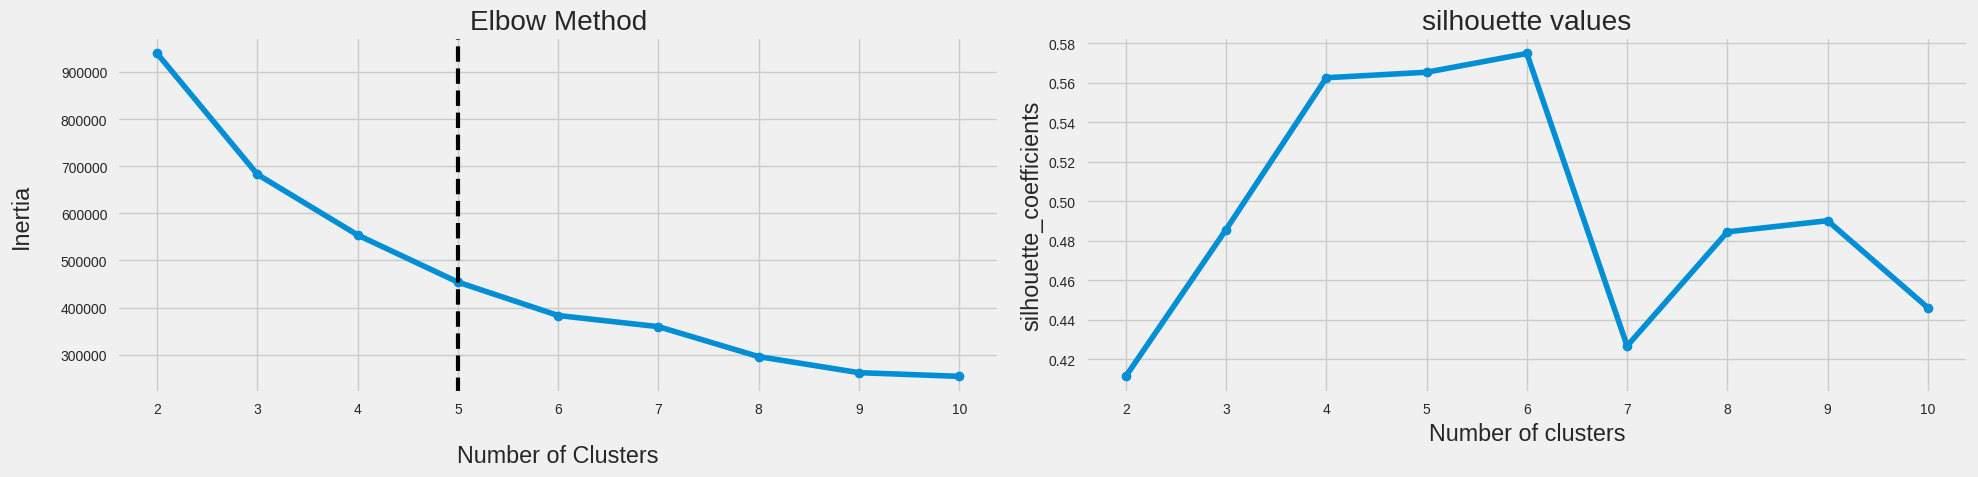

In [50]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(3,7), inertias, curve='convex', direction="decreasing") # KneeLocator is used to find the "elbow" point in the inertia plot
ax[0].plot(range(3,7), inertias ,marker='o',label='Elbow Method')
ax[0].set_xticks(range(3,7))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(3,7), silhouette_coefficients,marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(3,7))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout()

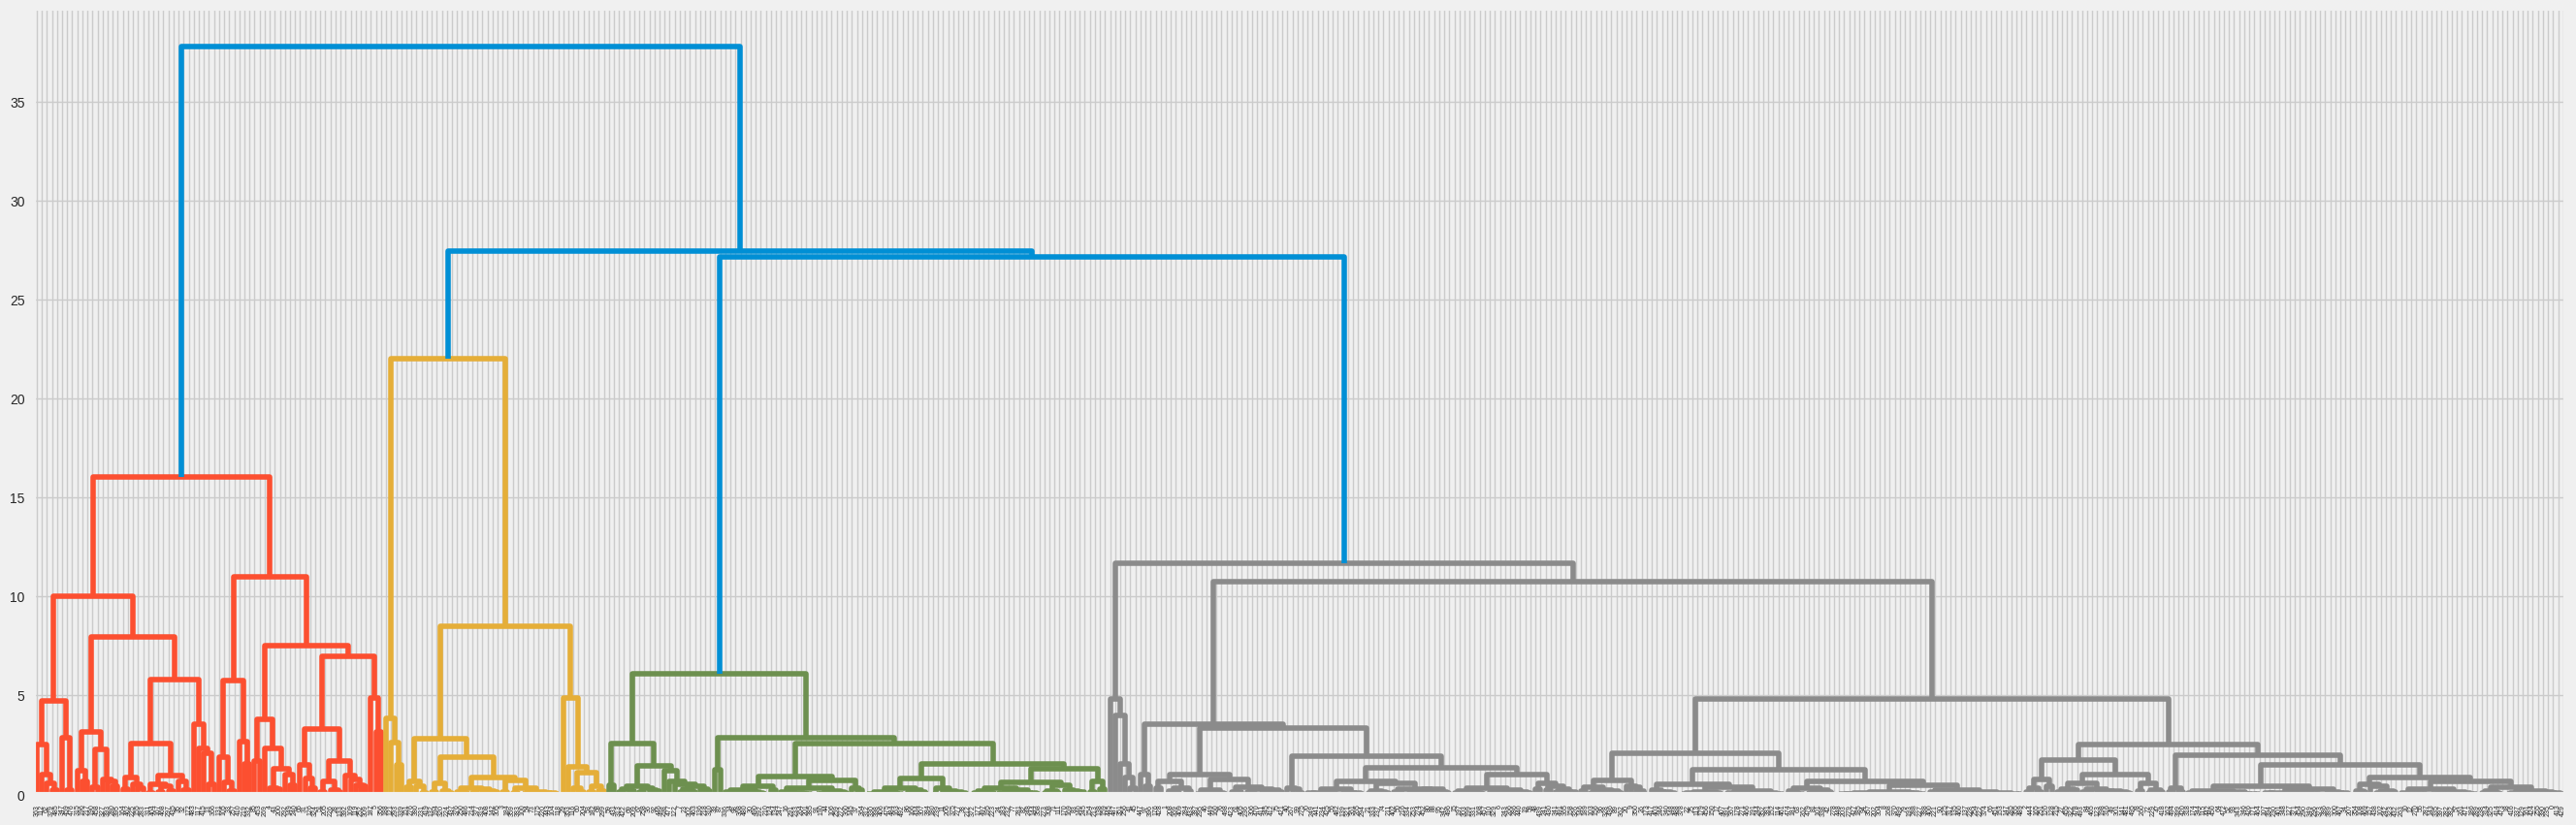

In [53]:
plt.figure(figsize=(30,10))
z = sch.linkage(df_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z)
plt.show()

### from the elbow method, we can see that the optimal K range is between 4 and 5 clusters, so we will narrow down a range of possible K values to [4, 6].
### from the silhouette method, we can see that the optimal K value in the range we specified is **6 clusters**.

In [68]:
kmeans = KMeans(n_clusters=6 , **kmeans_set) # **kmeans_set is used to unpack the dictionary
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetary,Age,Recency,Label
0,-0.400541,0.619109,-0.077011,-0.185321,0.445877,-0.310357,2
1,-0.400541,0.619109,-0.132205,-0.001427,1.269830,-0.310357,2
2,-0.400541,0.619109,-0.132837,0.452818,-0.069094,-0.310357,2
3,-0.400541,0.619109,0.357946,-0.157914,-2.643947,-0.310357,0
4,1.897629,-1.615225,-0.117748,-0.202413,0.394379,1.797906,5


In [69]:
df_scaled['Label'].value_counts()

Label
2    108813
3     41891
5     19717
0     18151
4     10691
1       737
Name: count, dtype: int64

In [73]:
attributes = df_scaled.columns[:6]
colors=['purple','yellow','red','blue','magenta','orange']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']

fig = go.Figure()
for index in range(0,6):
    fig.add_trace(go.Scatterpolar(r=np.mean(df_scaled.loc[df_scaled.Label == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.4,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

ValueError: 
    Invalid value of type 'numpy.float64' received for the 'r' property of scatterpolar
        Received value: -0.5068121348732955

    The 'r' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [ ]:
# Apply PCA for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled.drop('Label', axis=1))

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], 
                     c=df_scaled['Label'], 
                     cmap='rainbow',
                     alpha=0.6)
plt.title('K-means Clustering Results (PCA Visualization)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Print variance explained by PCA components
print(f"Variance explained by the first two components: {sum(pca.explained_variance_ratio_):.2%}")